In [1]:
%matplotlib nbagg
%load_ext autoreload

In [92]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from dask import delayed
from dask import array as da

import libertem
from libertem import api
from libertem.executor.dask import DelayedJobExecutor
from libertem.executor.inline import InlineJobExecutor

from libertem.udf.base import UDFRunner, UDF

In [3]:
%autoreload
delayed_e = DelayedJobExecutor()
ctx = api.Context(executor=delayed_e)
# inline_ctx = api.Context(executor=InlineJobExecutor())
# dist_ctx = api.Context()

In [4]:
ds = ctx.load(
    "auto",
    path=r"E:\LargeData\LargeData\ER-C-1\groups\data_science\data\reference\EMPAD\BiFeO3\acquisition_12.xml",
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))
cx = detector_x/2
cy = detector_y/2
y = scan_y//2
x = scan_x//2 + 1

In [5]:
%%time
pick_analysis = ctx.create_pick_analysis(dataset=ds, x=x, y=y)

Wall time: 0 ns


In [37]:
result = tasks[0]()

In [38]:
result

(<UDFData: {'intensity': <BufferWrapper kind=single dtype=float32 extra_shape=(1, 128, 128)>}>,)

In [6]:
%%time
%autoreload
d = UDFRunner([pick_analysis.get_udf()]).delayed_for_dataset(
    dataset=ds, executor=delayed_e, roi=pick_analysis.get_roi()
)

Wall time: 108 ms


In [11]:
%%time
delayed_result = d.compute()

Wall time: 68.3 ms


In [8]:
delayed_result

[{'intensity': <BufferWrapper kind=single dtype=float32 extra_shape=(1, 128, 128)>}]

In [9]:
%%time
%autoreload
direct = UDFRunner([pick_analysis.get_udf()]).run_for_dataset(
    dataset=ds, executor=delayed_e, roi=pick_analysis.get_roi()
)

Wall time: 185 ms


In [10]:
direct

[{'intensity': <BufferWrapper kind=single dtype=float32 extra_shape=(1, 128, 128)>}]

In [12]:
assert np.allclose(direct[0]['intensity'].raw_data, delayed_result[0]['intensity'].raw_data)

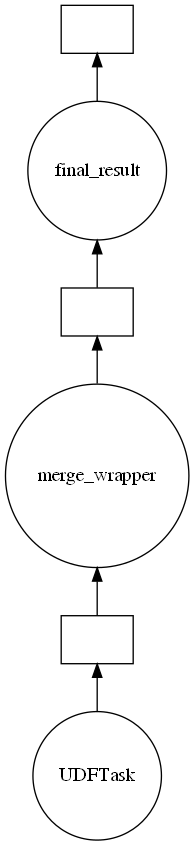

In [13]:
d.visualize()

In [ ]:
%time pick_result = ctx.run(pick_analysis, progress=True)

In [ ]:
%time pick_result = inline_ctx.run(pick_analysis, progress=True)

In [ ]:
%time pick_result = dist_ctx.run(pick_analysis, progress=True)

In [ ]:
print(pick_result)

In [ ]:
print(pick_result.intensity)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(pick_result.intensity.raw_data)

In [14]:
def all_ones():
    return np.ones((detector_y, detector_x))

In [15]:
def single_pixel():
    buf = np.zeros((detector_y, detector_x))
    buf[int(cy), int(cx)] = 1
    return buf

Here we use a mask UDF. This UDF uses the LiberTEM computation rather directly and returns a simple numerical result. See further below for examples that use the high-level analysis interface instead.

In [113]:
mask_udf = libertem.udf.masks.ApplyMasksUDF(mask_factories=[all_ones, single_pixel])
mask_udf_2 = libertem.udf.masks.ApplyMasksUDF(mask_factories=[all_ones, ])

In [114]:
%autoreload
runner = UDFRunner([mask_udf, mask_udf_2])
tasks = runner._prepare_run_for_dataset(
    dataset=ds,
    executor=delayed_e,
    roi=None,
    corrections=None,
    backends=None
)

In [115]:
tasks

[<UDFTask [<libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E01ACD0>, <libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E01AD30>]>,
 <UDFTask [<libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E015DF0>, <libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E015DC0>]>,
 <UDFTask [<libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E00B610>, <libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E00B5E0>]>,
 <UDFTask [<libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E00B250>, <libertem.udf.masks.ApplyMasksUDF object at 0x000001E94E00B220>]>]

In [116]:
task_results_delayed = delayed_e.delayed(tasks)

In [117]:
task_results = delayed()(task_results_delayed).compute()

In [124]:
def get_data(bufferwrapper):
    return bufferwrapper._data

def dask_array_from_buffer(bufferwrapper, shape, dtype):
    return da.from_delayed(delayed(get_data)(bufferwrapper), shape=shape, dtype=dtype)

for udf_index, udf in enumerate([mask_udf, mask_udf_2]):
    buffers = udf.get_result_buffers()
    for key, buffer in buffers.items():
        parts = []
        for task_index, task in enumerate(tasks):
            buffer.set_shape_partition(task.partition, roi=None)
            parts.append(
                dask_array_from_buffer(
                    bufferwrapper=task_results_delayed[task_index][0][udf_index][key],
                    shape=buffer._shape,
                    dtype=buffer._dtype
                )
            )
        tot = np.concatenate(parts)
        udf.results[key]._data = tot        

In [102]:
task_results[0][0][0]['intensity']._data

array([[2.78503245e+07, 9.86320117e+03],
       [2.84740825e+07, 1.18290654e+04],
       [2.92068387e+07, 6.49072412e+03],
       ...,
       [2.86518068e+07, 9.10700781e+03],
       [2.88504506e+07, 1.10876436e+04],
       [2.87880268e+07, 1.08316377e+04]])

In [105]:
mask_udf.results.as_dict()['intensity'].data.compute()

array([[[2.78503245e+07, 9.86320117e+03],
        [2.84740825e+07, 1.18290654e+04],
        [2.92068387e+07, 6.49072412e+03],
        ...,
        [2.84968498e+07, 7.89167090e+03],
        [2.83885469e+07, 6.46167285e+03],
        [2.82177730e+07, 6.60927197e+03]],

       [[2.86121717e+07, 1.14116309e+04],
        [2.89554789e+07, 1.35690986e+04],
        [2.95218254e+07, 7.54741357e+03],
        ...,
        [2.86293644e+07, 8.43088379e+03],
        [2.86971768e+07, 8.43308398e+03],
        [2.83712761e+07, 4.68074365e+03]],

       [[2.87745315e+07, 1.06156396e+04],
        [2.84225564e+07, 1.05717480e+04],
        [2.93321367e+07, 7.03878223e+03],
        ...,
        [2.87344133e+07, 1.21677715e+04],
        [2.88557739e+07, 7.04049707e+03],
        [2.89831992e+07, 7.99760059e+03]],

       ...,

       [[2.61672790e+07, 7.09153076e+03],
        [2.70597453e+07, 1.17709219e+04],
        [2.76607062e+07, 7.21484082e+03],
        ...,
        [2.71181134e+07, 5.46790283e+03],
     

In [125]:
mask_udf.results.as_dict()['intensity'].data

dask.array<reshape, shape=(256, 256, 2), dtype=float64, chunksize=(64, 256, 2), chunktype=numpy.ndarray>

In [107]:
delayed_intensity = mask_udf.results.as_dict()['intensity'].data.compute()

In [111]:
np.allclose(delayed_intensity, mask_udf_result['intensity'].data)

True

In [67]:
task_results[0][0][1]

TypeError: 'UDFTask' object is not subscriptable

In [63]:
task_results[0][0][0]['intensity']._data.shape

(16384, 2)

In [17]:
%%time
%autoreload
d = UDFRunner([mask_udf]).delayed_for_dataset(
    dataset=ds, executor=delayed_e
)

Wall time: 118 ms


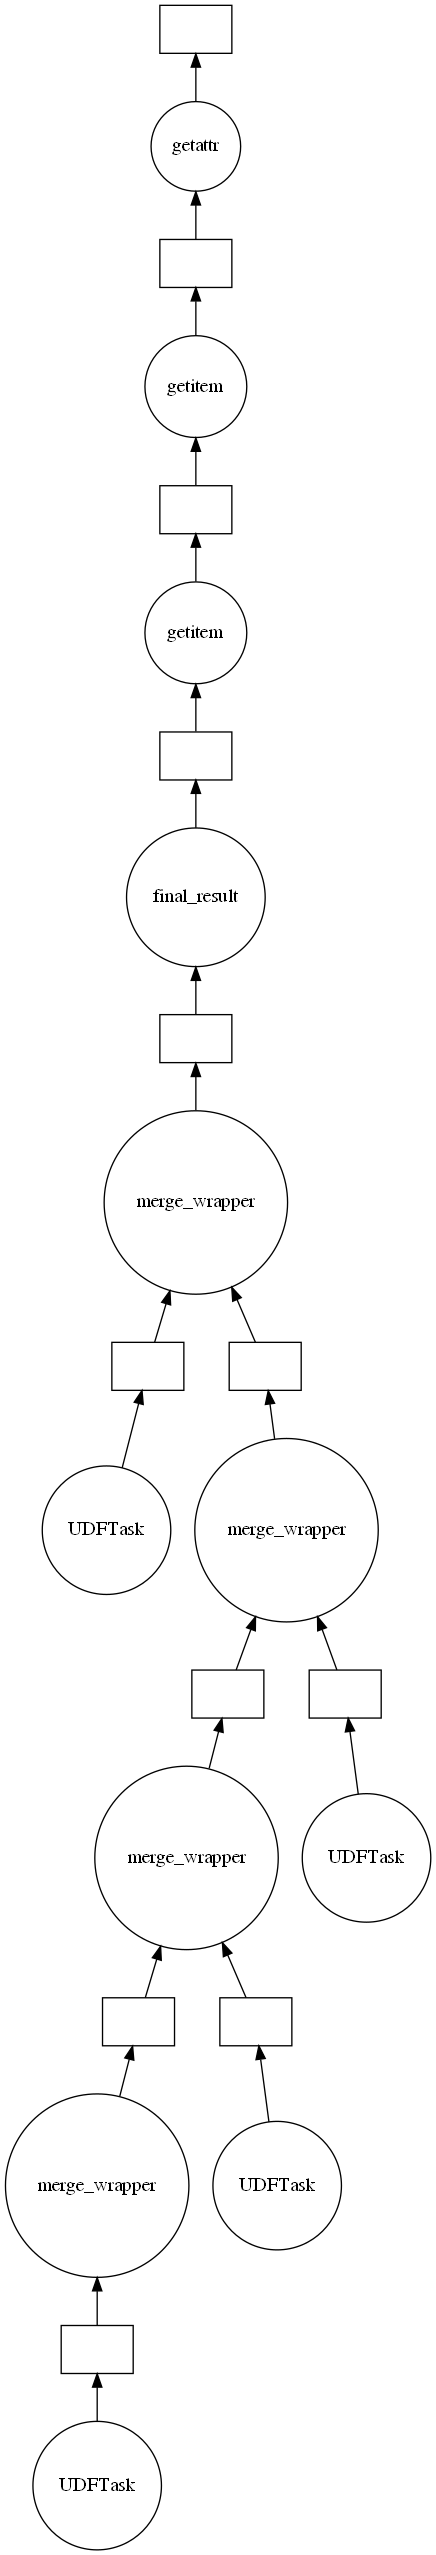

In [18]:
d[0]['intensity'].raw_data.visualize()

In [19]:
%%timeit
delayed_result = d.compute()

5.26 s ± 60.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
delayed_result

[{'intensity': <BufferWrapper kind=single dtype=float32 extra_shape=(1, 128, 128)>}]

In [110]:
mask_udf_result = ctx.run_udf(dataset=ds, udf=mask_udf, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.37s/it]


In [ ]:
assert np.allclose(delayed_result[0]['intensity'].raw_data, mask_udf_result['intensity'].raw_data)

In [77]:
%%time
mask_udf_result = inline_ctx.run_udf(dataset=ds, udf=mask_udf, progress=True)

NameError: name 'inline_ctx' is not defined

In [ ]:
%%time
mask_udf_result = dist_ctx.run_udf(dataset=ds, udf=mask_udf, progress=True)

In [ ]:
print(mask_udf_result)

In [ ]:
print(mask_udf_result['intensity'])

In [ ]:
fig, axes = plt.subplots()
axes.imshow(mask_udf_result['intensity'].data[..., 0], cmap=cm.gist_earth)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(mask_udf_result['intensity'].data[..., 1], cmap=cm.gist_earth)

In [ ]:
mask_analysis = ctx.create_mask_analysis(dataset=ds, factories=[all_ones, single_pixel])

In [ ]:
%time mask_analysis_result = ctx.run(mask_analysis, progress=True)

In [ ]:
print(mask_analysis_result)

In [ ]:
print(mask_analysis_result[0])

In [ ]:
fig, axes = plt.subplots()
axes.imshow(mask_analysis_result[0].visualized)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(mask_analysis_result[1].visualized)

In [ ]:
ro = min(detector_x,detector_y)/2
haadf_analysis = ctx.create_ring_analysis(dataset=ds, cx=cx, cy=cy, ro=ro, ri=ro*0.8)

In [ ]:
%time haadf_result = ctx.run(haadf_analysis, progress=True)

In [ ]:
print(haadf_result)

In [ ]:
print(haadf_result.intensity)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(haadf_result.intensity.visualized)

In [ ]:
bf_analysis = ctx.create_disk_analysis(dataset=ds, cx=cx, cy=cy, r=ro*0.3)

In [ ]:
%time bf_result = ctx.run(bf_analysis, progress=True)

In [ ]:
print(bf_result)

In [ ]:
print(bf_result.intensity)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(bf_result.intensity.visualized)

In [ ]:
point_analysis = ctx.create_point_analysis(dataset=ds, x=cx, y=cy)

In [ ]:
%time point_result = ctx.run(point_analysis, progress=True)

In [ ]:
print(point_result)

In [ ]:
print(point_result.intensity)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(point_result.intensity.visualized)

In [ ]:
sum_analysis = ctx.create_sum_analysis(dataset=ds)

In [ ]:
%time sum_result = ctx.run(sum_analysis, progress=True)

In [ ]:
print(sum_result)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(sum_result.intensity.raw_data)